# Our Goal ✨
1. Similarity Recommendation Based on Node2Vec
2. Let's Build a Recommendation System Using H&M Dataset!

Hello, Kagglers!

In this notebook, we'll try fashion recommendations using the Node2Vec algorithm, which is implemented by applying the simple concept of Graph Neural Network. Let's compare the images of clothes that the user purchased and the recommended clothes to see if the similarity score is reliable!

You can also find the .ipynb file that can be run all at once on this [GitHub link](https://github.com/H4Y3J1N/Graph-Travel/tree/H4Y3J1N).

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import networkx as nx
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.image as mpimg
import random

In [5]:
articles = pd.read_csv('/Users/jimincheol/Documents/Project/H&M_GNN_추천/HnM_Project_data_slicing/articles.csv')
customers = pd.read_csv('/Users/jimincheol/Documents/Project/H&M_GNN_추천/HnM_Project_data_slicing/customers.csv')
sample_submission = pd.read_csv('/Users/jimincheol/Documents/Project/H&M_GNN_추천/HnM_Project_data_slicing/sample_submission.csv')
transactions = pd.read_csv('/Users/jimincheol/Documents/Project/H&M_GNN_추천/HnM_Project_data_slicing/transactions_train.csv')

In order to depict this dataset as a Graph, we need to retain only the meaningful rows. The goal is to reduce sparsity as much as possible for better performance.

So, the first thing to do is to calculate the frequency of 'article_id' (product ID) and 'customer_id' (user ID), and consider filtering only users who have many purchase records & products with many purchase records.

In [6]:
display(articles.columns)
display(customers.columns)
display(transactions.columns)

Index(['article_id', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc'],
      dtype='object')

Index(['customer_id', 'age', 'postal_code'], dtype='object')

Index(['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id'], dtype='object')

In [7]:
#  아이템 사용자별 id의 유니크한 갯수를 변수에 담음
item_freq = transactions.groupby('article_id')['customer_id'].nunique()
user_freq = transactions.groupby('customer_id')['article_id'].nunique()

display(item_freq)
display(user_freq)

article_id
108775015    76
108775044    54
108775051     1
110065001     8
110065002     4
             ..
946795001     1
947509001     1
949551001     2
949551002     1
952267001     2
Name: customer_id, Length: 44805, dtype: int64

customer_id
000538c14c490fee547e2703439f70bdb8748e2a62f875d63b7320c17ae20fc2    30
0011e0bd4c39195ff342c0ca0ac0601ce2b943a826550674298a5ba49d9f8e70    27
001968eb5b52125225a9bbca15d0d4e8bd8fd1d6874b767c27f552c5bffca225    29
001ef7c503e5407b6b836351b0415d3a226c587d4fb17b1e9edf9dcc836de02f    22
0021f82013462a5b4375944b35c4e88e464daf8d459cae357fcb99139e3ae83f    34
                                                                    ..
ffd8ad34e3731bff3e172dd2c258a0409b44266b8de24d0204d7abd128ba6e7e    33
ffdc6e00cb0a038f3cee8302fbb6add4f2285cba6f9de1475f6e46ade45ab228    27
fff2c0da0dae66718c16c03b8ba64e7c6bdfb00e87ceafb641f00949a2137a29    27
fffd0248a95c2e49fee876ff93598e2e20839e51b9b7678aab75d9e8f9f3c6c8    29
fffe836e77106fde6a3d0fd74882c4f4315c5255e38fd1b9093830dd748b2c90    30
Name: article_id, Length: 10000, dtype: int64

In [10]:
# 그중에서 유니크한 갯수를 100d이상으로 잡았지만 우리는 데이터수가 많지 않으므로 그냥 인덱스로만 넣는걸 추천
# items = item_freq[item_freq >= 100].index
# users = user_freq[user_freq >= 100].index

# 우리는 아이템에 대한 데이터를 건들이지 않았으므로 10개이상으로 소거시키는것도 나쁘지 않을거 같다.
items = item_freq[item_freq >= 10].index
users = user_freq.index

In [11]:
# 코드의 내용은 위에서 100개이상의 유니크한 수를 가진 아이템 사용자별 id에대한 transactions의 데이터 셋인데 우리는 아이템만 건들였다
# 따라서 밑에filtered_df 데이터프레임에 담겨진 정보는 아이템이 10개이상 구매되고 전체 고객에 관한 구매정보 데이터 프레임이다. 
filtered_df = transactions[transactions['article_id'].isin(items) & transactions['customer_id'].isin(users)]
filtered_df

t_dat                                        customer_id  \
0       2018-09-20  02d37b5d9116efbc2dc6420de3b30376039e2af283bead...   
1       2018-09-20  0465ce750bdf4e7cd4c685e399eabfdf97be36287d77dd...   
2       2018-09-20  0465ce750bdf4e7cd4c685e399eabfdf97be36287d77dd...   
3       2018-09-20  0465ce750bdf4e7cd4c685e399eabfdf97be36287d77dd...   
5       2018-09-20  06f7a798e75c326db63e92ea39f0dc624dbdab0ff4fe9f...   
...            ...                                                ...   
320203  2020-09-22  f46c1c86c9b542fa791037770ee1cb25c6aabae52333bb...   
320204  2020-09-22  f46c1c86c9b542fa791037770ee1cb25c6aabae52333bb...   
320205  2020-09-22  f60fe8638131e87bf2378ee4abfd31f9ffc48a9ab38b34...   
320206  2020-09-22  f60fe8638131e87bf2378ee4abfd31f9ffc48a9ab38b34...   
320207  2020-09-22  fc5f8088f270ae71aecfa8f45618529bb2ea0eedf5c1ae...   

        article_id     price  sales_channel_id  
0        684686001  0.038119                 1  
1        562252028  0.025407                 2  
2        562245059  0.020322                 2  
3        562252014  0.016932                 2  
5        541518023  0.030492                 2  
...            ...       ...               ...  
320203   898713001  0.067780                 1  
320204   919365008  0.021169                 1  
320205   798407001  0.006763                 1  
320206   827957002  0.016932                 1  
320207   720504001  0.033881                 1  

[198592 rows x 5 columns]

Next, let's aggregate to reflect the weight we learned in the previous tutorial on the edges. This is a more in-depth application of what we've learned on the journey so far. The weight given to the edge can contain various information values. By assigning appropriate values, we can also reflect in the graph how much the user prefers the item.

Let's take an example. Consider user 0, item A, and item B as nodes. If user 0 purchased item A 10 times and item B once... We could say the preference for item A is higher, right?

There are two edges connecting these three nodes. The edges that stretch from the user 0 node to each item node. What relation might these edges imply? It's the purchase history! Therefore, we can assign a weight of 10 to the edge connected to item A node and a weight of 1 to the edge connected to item B.

In [12]:
# freq는 frequency라는 이름으로 컬럼을 만들었다
freq = filtered_df.groupby(['customer_id', 'article_id']).size().reset_index(name='frequency')
freq

customer_id  article_id  \
0       000538c14c490fee547e2703439f70bdb8748e2a62f875...   244267032   
1       000538c14c490fee547e2703439f70bdb8748e2a62f875...   356289021   
2       000538c14c490fee547e2703439f70bdb8748e2a62f875...   419634001   
3       000538c14c490fee547e2703439f70bdb8748e2a62f875...   429313006   
4       000538c14c490fee547e2703439f70bdb8748e2a62f875...   501820045   
...                                                   ...         ...   
174753  fffe836e77106fde6a3d0fd74882c4f4315c5255e38fd1...   783346020   
174754  fffe836e77106fde6a3d0fd74882c4f4315c5255e38fd1...   790666001   
174755  fffe836e77106fde6a3d0fd74882c4f4315c5255e38fd1...   801309002   
174756  fffe836e77106fde6a3d0fd74882c4f4315c5255e38fd1...   826492002   
174757  fffe836e77106fde6a3d0fd74882c4f4315c5255e38fd1...   858565001   

        frequency  
0               1  
1               1  
2               1  
3               1  
4               1  
...           ...  
174753          1  
174754          1  
174755          1  
174756          1  
174757          1  

[174758 rows x 3 columns]

In [22]:
# GraphTravel_HM은 위에 있던 filtered_df와 freq를 customer_id,article_id기준으로 합쳐준것이다.
GraphTravel_HM = filtered_df.merge(freq, on=['customer_id', 'article_id'], how='left')
GraphTravel_HM 

t_dat                                        customer_id  \
0       2018-09-20  02d37b5d9116efbc2dc6420de3b30376039e2af283bead...   
1       2018-09-20  0465ce750bdf4e7cd4c685e399eabfdf97be36287d77dd...   
2       2018-09-20  0465ce750bdf4e7cd4c685e399eabfdf97be36287d77dd...   
3       2018-09-20  0465ce750bdf4e7cd4c685e399eabfdf97be36287d77dd...   
4       2018-09-20  06f7a798e75c326db63e92ea39f0dc624dbdab0ff4fe9f...   
...            ...                                                ...   
198587  2020-09-22  f46c1c86c9b542fa791037770ee1cb25c6aabae52333bb...   
198588  2020-09-22  f46c1c86c9b542fa791037770ee1cb25c6aabae52333bb...   
198589  2020-09-22  f60fe8638131e87bf2378ee4abfd31f9ffc48a9ab38b34...   
198590  2020-09-22  f60fe8638131e87bf2378ee4abfd31f9ffc48a9ab38b34...   
198591  2020-09-22  fc5f8088f270ae71aecfa8f45618529bb2ea0eedf5c1ae...   

        article_id     price  sales_channel_id  frequency  
0        684686001  0.038119                 1          1  
1        562252028  0.025407                 2          1  
2        562245059  0.020322                 2          1  
3        562252014  0.016932                 2          1  
4        541518023  0.030492                 2          1  
...            ...       ...               ...        ...  
198587   898713001  0.067780                 1          1  
198588   919365008  0.021169                 1          1  
198589   798407001  0.006763                 1          1  
198590   827957002  0.016932                 1          1  
198591   720504001  0.033881                 1          1  

[198592 rows x 6 columns]

In [23]:
# 원래는 frequency가 10 이상으로 잡혀있는데 우리는 데이터를 축소 시켰으므로 제한값을 더 낮춰야 할것 같다 
# GraphTravel_HM = GraphTravel_HM[GraphTravel_HM['frequency'] >= 10]
# 우선 1이상으로 진행 시켜봄(데이터 변화x)
GraphTravel_HM = GraphTravel_HM[GraphTravel_HM['frequency'] >= 1]
GraphTravel_HM

t_dat                                        customer_id  \
0       2018-09-20  02d37b5d9116efbc2dc6420de3b30376039e2af283bead...   
1       2018-09-20  0465ce750bdf4e7cd4c685e399eabfdf97be36287d77dd...   
2       2018-09-20  0465ce750bdf4e7cd4c685e399eabfdf97be36287d77dd...   
3       2018-09-20  0465ce750bdf4e7cd4c685e399eabfdf97be36287d77dd...   
4       2018-09-20  06f7a798e75c326db63e92ea39f0dc624dbdab0ff4fe9f...   
...            ...                                                ...   
198587  2020-09-22  f46c1c86c9b542fa791037770ee1cb25c6aabae52333bb...   
198588  2020-09-22  f46c1c86c9b542fa791037770ee1cb25c6aabae52333bb...   
198589  2020-09-22  f60fe8638131e87bf2378ee4abfd31f9ffc48a9ab38b34...   
198590  2020-09-22  f60fe8638131e87bf2378ee4abfd31f9ffc48a9ab38b34...   
198591  2020-09-22  fc5f8088f270ae71aecfa8f45618529bb2ea0eedf5c1ae...   

        article_id     price  sales_channel_id  frequency  
0        684686001  0.038119                 1          1  
1        562252028  0.025407                 2          1  
2        562245059  0.020322                 2          1  
3        562252014  0.016932                 2          1  
4        541518023  0.030492                 2          1  
...            ...       ...               ...        ...  
198587   898713001  0.067780                 1          1  
198588   919365008  0.021169                 1          1  
198589   798407001  0.006763                 1          1  
198590   827957002  0.016932                 1          1  
198591   720504001  0.033881                 1          1  

[198592 rows x 6 columns]


Now we have information that allows us to understand a specific user's preference (repeat purchase frequency) for an item. It seems we can assign weight information to the edge using the 'frequency' column!

> Is it okay to use weight and random walk search bias together?

Yes! Weights and search bias can be used simultaneously and do not conflict with each other. Each controls a different aspect of the random walk, and using them together allows for more detailed control over how the random walk navigates the graph. To explain each concept a little more,

1. Weight is used to indicate the importance of an edge and is used to determine the probability that the random walk algorithm will follow a particular edge. Edges with high weights have a higher probability of being chosen by the random walk than edges with low weights.

2. Search bias is controlled by the two parameters p and q in Node2Vec. These parameters control the degree to which the random walk prefers to revisit nodes it has visited before or visit new nodes it has not yet visited.

And lastly, in order to reflect only meaningful information in the Graph, the dataset was filtered to leave only rows of products purchased more than 10 times by a user. 

Now that some preprocessing seems to have been done, shall we take a moment to check the state of the dataset?

In [24]:
print("unique customer_id" , GraphTravel_HM.customer_id.nunique())
print("unique article_id" , GraphTravel_HM.article_id.nunique())

unique customer_id 9996
unique article_id 7909


Wow, the original transactions dataframe had as many as 31,788,324 rows. It has significantly reduced. It's quite surprising that there are still around 25,000 left, even though we filtered with quite a high value.

There are 922 unique users and 1,013 unique items remaining. It seems reasonable to expect quite useful recommendation results from this amount.

On one hand, I'm curious about the distribution of frequency values. Shall we draw it directly and check?

/var/folders/x_/f90km48x06x0wtfpr0xmjvxc0000gn/T/ipykernel_83662/521335795.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(GraphTravel_HM['frequency'], kde=True, bins=30)


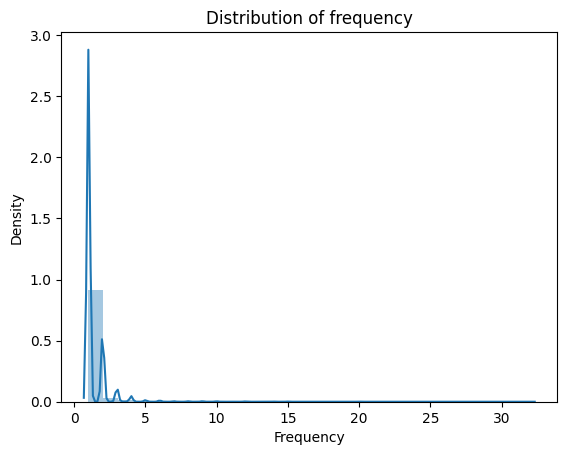

In [25]:
sns.distplot(GraphTravel_HM['frequency'], kde=True, bins=30)

plt.title('Distribution of frequency')
plt.xlabel('Frequency')
plt.ylabel('Density')

plt.show()

Considering we left only the products with more than 10 in the dataframe, the distribution is quite understandable. Most of the repurchase frequencies are concentrated between 10 and 100.

It looks like there's a product that's been purchased as many as 550 times... I wonder what this could be? Although EDA is not important to us right now and Erica will ignore her curiosity, those who are curious might find it fun to check for themselves.

Now, let's move to the final step of preprocessing. The values of customer_id were mixed with integers and strings as hash values, weren't they? I'll map these to integers. If it's an integer starting from 0, it's likely not to overlap with the article_id.

Also, to print the item name along with the recommendation result, I'll create one dictionary as well.

In [26]:
# 우리가 지금까지 만들었던 GraphTravel_HM의 소비자id의 중복되지않으값의 array list이다.
unique_customer_ids = GraphTravel_HM['customer_id'].unique()
unique_customer_ids

array(['02d37b5d9116efbc2dc6420de3b30376039e2af283beadcba3afc936e41ae715',
       '0465ce750bdf4e7cd4c685e399eabfdf97be36287d77dd4b01058ae0daef742b',
       '06f7a798e75c326db63e92ea39f0dc624dbdab0ff4fe9fe5b5e72b1129ead3a1',
       ...,
       'bb13f4196b851d900d7da2769878d32da314102726c8c67237ed3582e5195faf',
       '11e2ae3ebb010b7cd5c1d667b96e8e0248fd096b411ab9b486a7ee3bf18f459d',
       '279d88b7b394d0a678d718ee9e2b3d09172843ea6bfdda6cb823ebd420d7b21b'],
      dtype=object)

In [27]:
# 위에서 구한 array를 인덱스와 값을 가지고 와서 딕셔너리로 만든것의 변수이다.
customer_id_mapping = {id: i for i, id in enumerate(unique_customer_ids)}
customer_id_mapping

{'02d37b5d9116efbc2dc6420de3b30376039e2af283beadcba3afc936e41ae715': 0,
 '0465ce750bdf4e7cd4c685e399eabfdf97be36287d77dd4b01058ae0daef742b': 1,
 '06f7a798e75c326db63e92ea39f0dc624dbdab0ff4fe9fe5b5e72b1129ead3a1': 2,
 '07f9c831ac42a1413430969c4dc2f2de4cf8d9b8b7cc411c375209830e739ab0': 3,
 '09ea4d2734b06097b3949c99bde7447336c6f40c1dfb3000bd8434abd7f929bb': 4,
 '0a111f5882ba8402518b780e00fff45e478f70e41d4a841f6dc1cccc35750aaa': 5,
 '104dddd377a3542da33552b3a65752d03e196b4fdf8f3650974546eb449db0ff': 6,
 '1073a5d0cbb0f752878d54fefd734b3e146980b7610b35144cabc1c309d6f53c': 7,
 '10f570ced909001887d33d1d01d8ad93f261a4c35cd47432b2d9ff7577996d3a': 8,
 '14a1594414c10cc4d0d4dc0054d7fad60f9ce7af6dc5ba6fb4aab8aac8214232': 9,
 '15d457bcfb1ab063fb7e4abeffbb053d7ce904fede88ef3f7719beeb3dcf035d': 10,
 '16b25dd51dc66f6e708ae8440b27dbc4a638d2c33cbe369c2ee7ba86464ef107': 11,
 '16eb109b578974a762c2035a7e4c41bce1d2b9f56a6ef3b27f274fd3e1f1d883': 12,
 '1929f41028b0ea66bc7289271979915ecea11cc68d12569cdfee9552edb

In [28]:
# 위에서 만든 딕셔너리를 다시GraphTravel_HM에 맴핑 시킨것이다.
GraphTravel_HM['customer_id'] = GraphTravel_HM['customer_id'].map(customer_id_mapping)
GraphTravel_HM['customer_id']

0            0
1            1
2            1
3            1
4            2
          ... 
198587    2085
198588    2085
198589    9861
198590    9861
198591    6500
Name: customer_id, Length: 198592, dtype: int64

In [29]:
# 아이템 id와 그 id의 제품이름을 딕셔너리로 만든 변수이다.
item_name_mapping = dict(zip(articles['article_id'], articles['prod_name'])) # prod_name
item_name_mapping

{108775015: 'Strap top',
 108775044: 'Strap top',
 108775051: 'Strap top (1)',
 110065001: 'OP T-shirt (Idro)',
 110065002: 'OP T-shirt (Idro)',
 110065011: 'OP T-shirt (Idro)',
 111565001: '20 den 1p Stockings',
 111565003: '20 den 1p Stockings',
 111586001: 'Shape Up 30 den 1p Tights',
 111593001: 'Support 40 den 1p Tights',
 111609001: '200 den 1p Tights',
 112679048: 'SWEATSHIRT  OC',
 112679052: 'SWEATSHIRT  OC',
 114428026: 'Alice BANDEAU 2-p',
 114428030: 'Alice BANDEAU 2-p',
 116379047: 'Frugan longsleeve',
 118458003: 'Jerry jogger bottoms',
 118458004: 'Jerry jogger bottoms',
 118458028: 'Jerry jogger bottoms',
 118458029: 'Jerry jogger bottoms',
 118458034: 'Jerry jogger bottoms',
 118458038: 'Jerry jogger bottoms',
 118458039: 'Jerry jogger bottoms',
 120129001: 'Babette long',
 120129014: 'Babette long',
 120129018: 'Babette long',
 120129025: 'Babette long',
 123173001: 'Control Top 50 den 1p Tights',
 126589006: '2p Claw',
 126589007: '2p Claw',
 126589010: '2p Claw',
 1

Now that the preprocessing for building a recommendation system is complete, let's officially create a Graph.

After creating the graph, I will implement and apply the Biased Random Walk and Generate Walk code.
While we're at it, let's proceed straight through the process of extracting embeddings with the Word2Vec model!

In [30]:
# 제가 생각 하기엔 여기가 이제 gnn적용 인거 같다.
G = nx.Graph()

for index, row in GraphTravel_HM.iterrows():
    G.add_node(row['customer_id'], type='user')
    G.add_node(row['article_id'], type='item')
    G.add_edge(row['customer_id'], row['article_id'], weight=row['frequency'])

G

In [31]:
# biased random walk  
def biased_random_walk(G, start_node, walk_length, p=1, q=1):
    walk = [start_node]

    while len(walk) < walk_length:
        cur_node = walk[-1]
        cur_neighbors = list(G.neighbors(cur_node))

        if len(cur_neighbors) > 0:
            if len(walk) == 1:
                walk.append(random.choice(cur_neighbors))
            else:
                prev_node = walk[-2]

                probability = []
                for neighbor in cur_neighbors:
                    if neighbor == prev_node:
                        # Return parameter 
                        probability.append(1/p)
                    elif G.has_edge(neighbor, prev_node):
                        # Stay parameter 
                        probability.append(1)
                    else:
                        # In-out parameter 
                        probability.append(1/q)

                probability = np.array(probability)
                probability = probability / probability.sum()  # normalize

                next_node = np.random.choice(cur_neighbors, p=probability)
                walk.append(next_node)
        else:
            break

    return walk

In [32]:
def generate_walks(G, num_walks, walk_length, p=1, q=1):
    walks = []
    nodes = list(G.nodes())
    for _ in range(num_walks):
        random.shuffle(nodes)  # to ensure randomness
        for node in nodes:
            walk_from_node = biased_random_walk(G, node, walk_length, p, q)
            walks.append(walk_from_node)
    return walks

In [ ]:
# generate_walks(G, 2, 8, p=0.5, q=0.5)

In [33]:
# Random Walk 
walks = generate_walks(G, num_walks=10, walk_length=20, p=9, q=1)
walks

[[4916,
  484398001,
  114,
  720125001,
  8461,
  796137001,
  9295,
  723151001,
  2829,
  687034010,
  8117,
  699077006,
  7311,
  559634027,
  4604,
  599580012,
  98,
  464297007,
  1109,
  560047002],
 [1819,
  816423001,
  9750,
  524529004,
  4978,
  706016006,
  5845,
  824497002,
  609,
  756428002,
  7140,
  817472001,
  3893,
  817472005,
  4489,
  664074018,
  5115,
  832330003,
  6584,
  811907006],
 [6364,
  693242002,
  1977,
  714826002,
  4808,
  563519008,
  6536,
  697489001,
  2962,
  665657003,
  4017,
  711521001,
  460,
  756322001,
  99,
  673677002,
  6168,
  572533002,
  2224,
  687270002],
 [757303001,
  8967,
  511105004,
  2482,
  663679002,
  217,
  594264003,
  7183,
  153115019,
  6761,
  753214007,
  3184,
  598806001,
  1067,
  708466003,
  8568,
  832309010,
  2154,
  753210001,
  7756],
 [754002001,
  2723,
  678715002,
  2489,
  751372001,
  2085,
  919365008,
  8146,
  736531005,
  8334,
  838900003,
  9487,
  754262005,
  4656,
  739953003,
  60

In [34]:
filtered_walks = [walk for walk in walks if len(walk) >= 5]
filtered_walks

[[4916,
  484398001,
  114,
  720125001,
  8461,
  796137001,
  9295,
  723151001,
  2829,
  687034010,
  8117,
  699077006,
  7311,
  559634027,
  4604,
  599580012,
  98,
  464297007,
  1109,
  560047002],
 [1819,
  816423001,
  9750,
  524529004,
  4978,
  706016006,
  5845,
  824497002,
  609,
  756428002,
  7140,
  817472001,
  3893,
  817472005,
  4489,
  664074018,
  5115,
  832330003,
  6584,
  811907006],
 [6364,
  693242002,
  1977,
  714826002,
  4808,
  563519008,
  6536,
  697489001,
  2962,
  665657003,
  4017,
  711521001,
  460,
  756322001,
  99,
  673677002,
  6168,
  572533002,
  2224,
  687270002],
 [757303001,
  8967,
  511105004,
  2482,
  663679002,
  217,
  594264003,
  7183,
  153115019,
  6761,
  753214007,
  3184,
  598806001,
  1067,
  708466003,
  8568,
  832309010,
  2154,
  753210001,
  7756],
 [754002001,
  2723,
  678715002,
  2489,
  751372001,
  2085,
  919365008,
  8146,
  736531005,
  8334,
  838900003,
  9487,
  754262005,
  4656,
  739953003,
  60

In [35]:
# to String  (for Word2Vec input)
walks = [[str(node) for node in walk] for walk in walks]
walks

[['4916',
  '484398001',
  '114',
  '720125001',
  '8461',
  '796137001',
  '9295',
  '723151001',
  '2829',
  '687034010',
  '8117',
  '699077006',
  '7311',
  '559634027',
  '4604',
  '599580012',
  '98',
  '464297007',
  '1109',
  '560047002'],
 ['1819',
  '816423001',
  '9750',
  '524529004',
  '4978',
  '706016006',
  '5845',
  '824497002',
  '609',
  '756428002',
  '7140',
  '817472001',
  '3893',
  '817472005',
  '4489',
  '664074018',
  '5115',
  '832330003',
  '6584',
  '811907006'],
 ['6364',
  '693242002',
  '1977',
  '714826002',
  '4808',
  '563519008',
  '6536',
  '697489001',
  '2962',
  '665657003',
  '4017',
  '711521001',
  '460',
  '756322001',
  '99',
  '673677002',
  '6168',
  '572533002',
  '2224',
  '687270002'],
 ['757303001',
  '8967',
  '511105004',
  '2482',
  '663679002',
  '217',
  '594264003',
  '7183',
  '153115019',
  '6761',
  '753214007',
  '3184',
  '598806001',
  '1067',
  '708466003',
  '8568',
  '832309010',
  '2154',
  '753210001',
  '7756'],
 ['7

In [36]:
# Word2Vec train
model = Word2Vec(walks, vector_size=128, window=5, min_count=0,  hs=1, sg=1, workers=4, epochs=10)
model

In [37]:
# node embedding extract
embeddings = {node_id: model.wv[node_id] for node_id in model.wv.index_to_key}
embeddings

{'706016001': array([-0.14759745, -0.10531135,  0.00573146, -0.00703807, -0.16716464,
        -0.17030077,  0.19671495, -0.16221207,  0.05710226, -0.08655867,
         0.1772682 ,  0.12892056,  0.10807782, -0.16332331, -0.16566527,
        -0.15443122, -0.2331981 , -0.01407191, -0.2466487 ,  0.03725178,
         0.29308584,  0.2511204 ,  0.12058434,  0.01883587, -0.44214737,
         0.06896752, -0.12980068, -0.1405321 ,  0.02145035, -0.13386105,
        -0.06952035,  0.03495603,  0.04413372,  0.20780131,  0.02568937,
         0.35683596,  0.29992345, -0.25828254,  0.10175005,  0.57938755,
         0.02815034,  0.0819205 , -0.166908  , -0.14495696, -0.05407035,
        -0.01669516, -0.0575764 ,  0.14044681, -0.05164434, -0.13334209,
        -0.11588042,  0.08729059, -0.24804054,  0.2845923 , -0.23784745,
        -0.06487632, -0.1751772 , -0.1688114 ,  0.03455526,  0.24129497,
        -0.29637364, -0.16763245,  0.04671439, -0.23592225,  0.21925119,
        -0.034139  ,  0.16193072,  0.2

In [ ]:
# embeddings

In the middle of the code, it might be good to run the generate_walks() method separately or to print out the embeddings to visually check their shape at least once.

The line of code creating the Random Walk is a point of interest. In this tutorial code, p is set very high as generate_walks(G, num_walks=10, walk_length=20, p=9, q=1). I hope you try changing this number yourself and check how the recommendation result changes!


## get_user_embedding 

This function returns the Embedding of the given user Node. Here, embedding refers to a vector that quantifies the user's preferences or behavior patterns. This vector is used in the item recommendation algorithm we are implementing to calculate the similarity between the user and the item.

In [38]:
def get_user_embedding(user_id, embeddings):
    return embeddings[str(user_id)]

## get_rated_items

This function returns a list of items already rated (or purchased) by the given user. This information will be used to exclude items already rated by the user from the recommendation list.
Of course, there's no rule that items with a history of purchase should not be recommended, and it could help encourage repurchase... but if the recommendation list becomes an order review list, there's no point in creating embeddings, right?

I will set the purpose of this recommendation system to recommend unseen items. That means I'm going to recommend items that the user hasn't bought yet but might like!

In [39]:
def get_rated_items(user_id, df):
    return set(df[df['customer_id'] == user_id]['article_id'])

## calculate_similarities

This function calculates the similarity between the given user and all items, and returns this similarity as a list along with the item ID. In other words, it will calculate the cosine similarity between the user embedding and the embedding of each item. Items that the user has already rated are excluded from the similarity calculation.

In [40]:
def calculate_similarities(user_id, df, embeddings):
    rated_items = get_rated_items(user_id, df)
    user_embedding = get_user_embedding(user_id, embeddings)

    item_similarities = []
    for item_id in set(df['article_id']):
        if item_id not in rated_items:  
            item_embedding = embeddings[str(item_id)]
            similarity = cosine_similarity([user_embedding], [item_embedding])[0][0]
            item_similarities.append((item_id, similarity))

    return item_similarities

## show_images

This is a function that takes a list of items as input, prints out images for each item, and also prints out the similarity score. The item list given as input includes both the item ID and similarity.

Since our currently implemented similarity-based recommendation system doesn't have a separately defined label to judge the accuracy of recommendations, we implemented the tutorial code to be able to see the images together in order to intuitively check the results of the recommendation system!

In [41]:
def show_images(items, item_name_mapping, num_items, show_similarity=False):
    f, ax = plt.subplots(1, num_items, figsize=(20,10))
    if num_items == 1:
        ax = [ax]
    for i, item in enumerate(items):
        item_id, similarity = item
        print(f"- Item {item_id}: {item_name_mapping[item_id]}", end='')
        if show_similarity:
            print(f" with similarity score: {similarity}")
        else:
            print()
        img_path = f"/Users/jimincheol/Documents/Project/H&M_GNN_추천/HnM_Project_data/images/0{str(item_id)[:2]}/0{int(item_id)}.jpg"
        try:
            img = mpimg.imread(img_path)
            ax[i].imshow(img)
            ax[i].set_title(f'Item {item_id}')
            ax[i].set_xticks([], [])
            ax[i].set_yticks([], [])
            ax[i].grid(False)
        except FileNotFoundError:
            print(f"Image for item {item_id} not found.")
    plt.show()

## recommend_items

This function places the functions defined above appropriately, and outputs the final recommendation result. Ultimately, it finds items that are close in Embedding distance based on the user's transaction history, in other words, items the user might like, or in other words, the most similar items, and visually outputs the result.

It means that you can present a recommendation result that can be called personalized recommendation!

In [42]:

def recommend_items(user_id, df, embeddings, item_name_mapping, num_items=5):
    rated_items = get_rated_items(user_id, df)
    
    print(f"User {user_id} has purchased:")
    show_images([(item_id, 0) for item_id in list(rated_items)[:5]], item_name_mapping, min(len(rated_items), 5))
    
    item_similarities = calculate_similarities(user_id, df, embeddings)

    recommended_items = sorted(item_similarities, key=lambda x: x[1], reverse=True)[:num_items]

    print(f"\nRecommended items for user {user_id}:")
    show_images(recommended_items, item_name_mapping, num_items, show_similarity=True)


I made this code to output the top 5 recommended results.
To be able to judge visually whether it was a good recommendation, I arranged not only the similarity score but also the image.

1. It prints out five items that the user has purchased in the past, and
2. It presents five items with high similarity that are considered to be likable to the user.

In this way, you can judge whether it is a completely arbitrary recommendation or not, even without an accuracy score or labels, through similarity scores and images. Well, shall we finally activate the long-awaited first recommendation system?

User 45 has purchased:
- Item 640124001: Leeds Jumper
- Item 654772001: Sally Multi Structure
- Item 632516001: Carino
- Item 573085028: Madison skinny HW
- Item 539723001: Jade Denim TRS


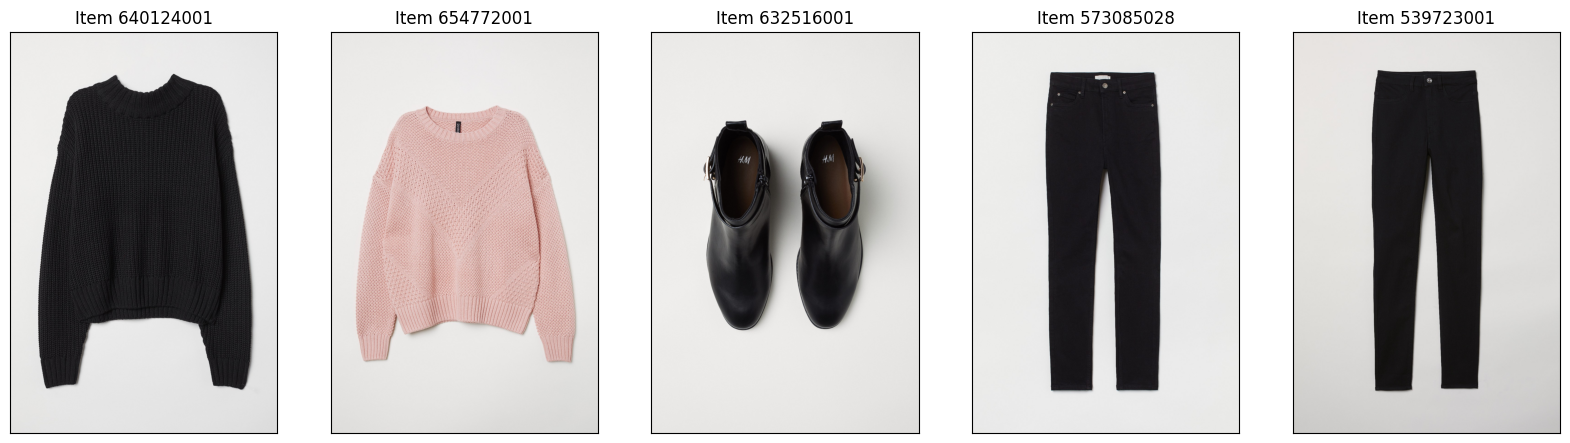


Recommended items for user 45:
- Item 829302003: Pingu spring with similarity score: 0.3926185667514801
- Item 556539028: Velvet scrunchie with similarity score: 0.3642329275608063
- Item 659832009: Leonora off-shoulder with similarity score: 0.3569164276123047
- Item 620425001: Karin headband with similarity score: 0.3561112582683563
- Item 562245055: Luna skinny RW with similarity score: 0.3545922338962555


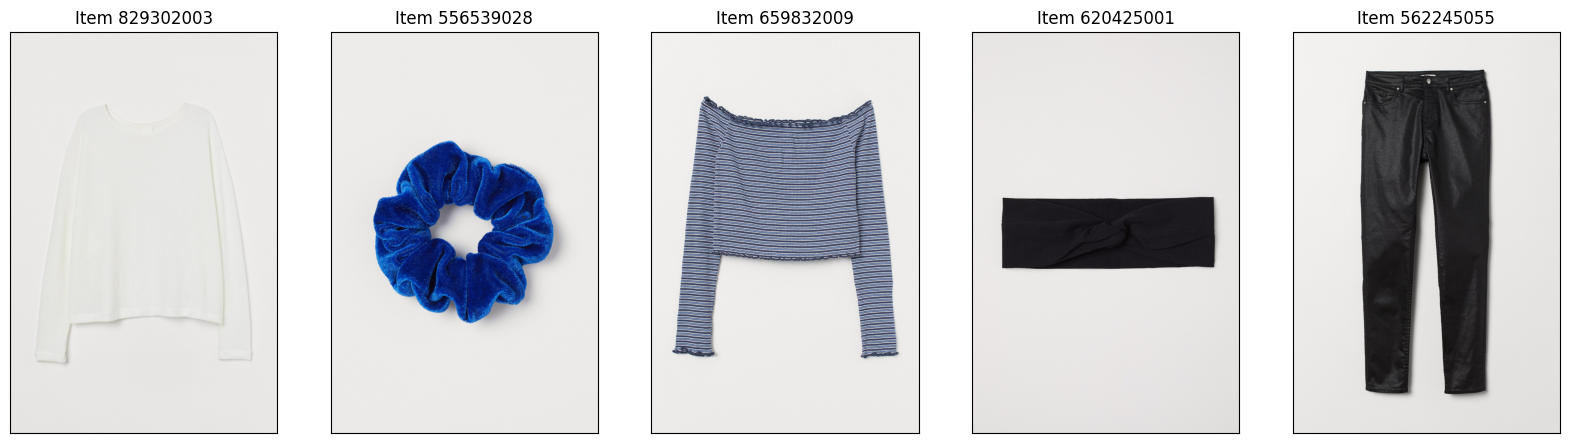

In [43]:
# costomer 45's top 5 
recommend_items(45, GraphTravel_HM, embeddings, item_name_mapping, num_items=5)

Oh, quite interesting results came out, didn't they? Of course, it's more of a dream interpretation... The clothes that User 45 has purchased have the following design commonalities:

1. Casual and comfortable clothes
2. Clothes with shirring (wrinkles)
3. Preference for both vivid primary colors and achromatic colors

And the recommended items also seem to have similar commonalities! Plus, a hoodie is also recommended. It seems like we've made quite a decent recommendation with a simple code.

It would also be fun to manually print out the recommended results for other users by changing the numbers.

# If this tutorial was helpful, please Upvote! 🥰

혹시 한국인인가요? 이 튜토리얼 코드의 한국어 버전이 필요하다면, Graph User Group 사이트에 찾아오세요!

GUG에서는 매주 GNN 기술을 논문과 연계해 공유하는 뉴스레터와, 튜토리얼이 연재되고 있답니다.

✈🎫 Want to know about GUG? [Link](https://www.graphusergroup.com/)